In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!pip install tf2cv tensorflow>=2.0.0

In [3]:
from tensorflow.python.client import device_lib
dev=device_lib.list_local_devices()
dev[len(dev)-1]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17460631093511131012
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"

In [0]:
#global consts
IMG_SIZE='137x236'
HEIGHT = 137
WIDTH = 236
BATCH_SIZE=128
DROP_OUT=0.0
FOLD=0
TRAIN_DIR = './train/'
TRAIN_IMG_DIR=TRAIN_DIR+str(IMG_SIZE)
EPOCHS = 200
STATS_FS = (0.055029564364430086, 0.17228061284674265)
STATS_128 = (0.0692, 0.2051)
STATS_FS_WOINORM = (0,1)
EXPERIMENT='sernext_fs_woinorm'
INPUT_DIR ='/content/drive/My Drive/kaggle/bengali/input/'
OUTPUT_DIR = '/content/drive/My Drive/kaggle/bengali/output/'
IMPORT_DIR = '/content/drive/My Drive/kaggle/bengali/nbs/'
EXPERIMENT_DIR = OUTPUT_DIR + EXPERIMENT+'/'
CHKP_DIR = EXPERIMENT_DIR+'chkp/'
OUTPUT_SUBDIR = ''
DATASET_224='224x224-bengali.zip'
DATASET_128='grapheme-imgs-128x128.zip'
DATASET_FS = 'bengali-full-size.zip'
DATASET_FS_WOINORM ='bengali-137x236-woinorm.zip'
TRAIN_WITH_FOLD = 'train_with_fold_20.csv'
PRETRAINED = False
PRETRAINED_WEIGHTS = ''
LOG_FILE = EXPERIMENT_DIR+'log_'+EXPERIMENT+'.csv'
#INITIAL_EPOCH=40
#HEAD_WD=1e-3
#BACKBONE_WD = 1e-4

if IMG_SIZE == 128: DATASET=DATASET_128
if IMG_SIZE == 224: DATASET=DATASET_224
if IMG_SIZE == '137x236' : DATASET=DATASET_FS_WOINORM


#lr sheduler consts
LR_MAX = 0.001
LR_MIN = 0.00001
T_MAX = 100

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append(IMPORT_DIR+'py/models/')
sys.path.append(IMPORT_DIR+'py/utils/')
sys.path.append(IMPORT_DIR+'py/callbacks/')
sys.path.append(IMPORT_DIR+'py/opts/')

In [0]:
#import local modules
#from mish import Mish,mish
from generators import *
from kaggle_metric import *
#from cosine import CosineAnnealingScheduler
from kagglevalidation import KaggleValidationFS
#from lookahead import Lookahead
from se_resnext50 import build_se_resnext50_model_fs_wod
#from md121v2 import build_md121_v2_model
#from losses import categorical_focal_loss


#import external modules
import numpy as np 
import pandas as pd 

import os
import errno

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight

In [10]:
try:
  os.mkdir(TRAIN_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_DIR+' already exists')
    else:
        raise
try:
  os.mkdir(TRAIN_IMG_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_IMG_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(EXPERIMENT_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(EXPERIMENT_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(CHKP_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(CHKP_DIR+' already exists')
    else:
        raise


os.system('cp '+ '"'+INPUT_DIR+DATASET+'" ' + TRAIN_DIR)
os.system('cp '+ '"'+INPUT_DIR+TRAIN_WITH_FOLD+'" ' + TRAIN_DIR)

./train/ already exists
./train/137x236 already exists


0

In [0]:
if PRETRAINED: os.system('cp '+ '"'+OUTPUT_DIR+OUTPUT_SUBDIR+PRETRAINED_WEIGHTS+'" '+TRAIN_DIR)

In [12]:
os.system('unzip -q '+TRAIN_DIR+DATASET+ ' -d '+ TRAIN_IMG_DIR)

0

In [13]:
!ls train

137x236  bengali-137x236-woinorm.zip  train_with_fold_20.csv


In [0]:
dataset_np = pd.read_csv(TRAIN_DIR+TRAIN_WITH_FOLD).to_numpy()
dataset_np[:,0]+='.png'
dataset_m = dataset_np.shape[0]


valid_m = np.where(dataset_np[:,6]==FOLD)[0].shape[0]
train_m = dataset_m-valid_m

fold_train_inds = np.where(dataset_np[:,6] != FOLD)
fold_valid_inds = np.where(dataset_np[:,6] == FOLD)

train_np = dataset_np[fold_train_inds]
valid_np = dataset_np[fold_valid_inds]

train_df = pd.DataFrame(train_np)
valid_df = pd.DataFrame(valid_np)

train_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)
valid_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)

train_df.drop(columns=[5,6], inplace=True)
valid_df.drop(columns=[5,6], inplace=True)

In [0]:
cons_unique=np.unique(train_np[:,3])
cons_y_train = train_np[:,3]
vowel_unique=np.unique(train_np[:,2])
vowel_y_train = train_np[:,2]
root_unique =np.unique(train_np[:,1])
root_y_train = train_np[:,1]

cons_class_weights = class_weight.compute_class_weight('balanced',
                                                 cons_unique,
                                                 cons_y_train)

vowel_class_weights = class_weight.compute_class_weight('balanced',
                                                 vowel_unique,
                                                 vowel_y_train)

root_class_weights = class_weight.compute_class_weight('balanced',
                                                 root_unique,
                                                 root_y_train)
cons_cw_dict=dict(enumerate(cons_class_weights))
vowel_cw_dict=dict(enumerate(vowel_class_weights))
root_cw_dict=dict(enumerate(root_class_weights))

model_cw={}
model_cw['root']=root_cw_dict
model_cw['vowel']=vowel_cw_dict
model_cw['consonant']=cons_cw_dict

In [0]:
model =  build_se_resnext50_model_fs_wod(height=HEIGHT, width=WIDTH)

In [0]:
if 0: model.summary()

In [0]:
if 0:
  from tensorflow.keras.utils import plot_model
  plot_model(model, to_file=OUTPUT_DIR+'model3.png',show_shapes=True)

In [0]:
if 0:
  for (n, layer) in enumerate(model.layers[1].layers):
    if 'activation' in layer.get_config() and layer.get_config()['activation'] == 'relu':
      print('replacing #{}: {}, {}'.format(n, layer, layer.activation))
      layer.activation = Mish(mish)
      print('-> {}'.format(layer.activation))

In [20]:
TRAIN_DIR+PRETRAINED_WEIGHTS

'./train/'

In [0]:
if 0: 
  model.load_weights(TRAIN_DIR+PRETRAINED_WEIGHTS)
  valid_gen = test_batch_generator(valid_df,TRAIN_IMG_DIR,batch_size=512)
  root_predicts,vowel_predicts,cons_predicts=get_p_dicts(model,valid_gen)
  root_recalls,_,_ = compute_cm(valid_df,root_predicts,vowel_predicts,cons_predicts)
  root_weights = 1./np.power(root_recalls,2)
else:
  root_weights = 1.0


In [0]:
if 0: root_weights[62]

In [0]:
cutout_datagen = ImageDataGenerator(
                                    rotation_range = 15,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   preprocessing_function=get_random_eraser(s_l=0.05,s_h=0.1,r_1=0.8,r_2=1.2,v_l=255,v_h=255))

mcm_datagen = ImageDataGenerator(
                                  rotation_range = 15,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

In [51]:
columns=["root_class","vowel_class", "cons_class"]

mcm_generator1 = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")

mcm_generator2 = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")


cutout_generator = cutout_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")

Found 190798 validated image filenames.
Found 190798 validated image filenames.
Found 190798 validated image filenames.


In [0]:
def cutout_batch_fs(batch, p=0.5, s_l=0.05,s_h=0.3,r_1=0.2,r_2=5.0, st=STATS_FS):
        x,y = prep_batch_fs(batch,st=st)
        p_1 = np.random.rand()

        if p_1 > p:
            return x,y

        bs,img_h, img_w, img_c = x.shape

        for i in range(bs):
          while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

          x[i,top:top + h, left:left + w, :] = 0

        return x,y

In [0]:
def ps_batch_fs(batch, n=4, p=0.5, s_l=0.05,s_h=0.15,r_1=0.8,r_2=1.2, st=STATS_FS):
        x,y = prep_batch_fs(batch,st=st)
        p_1 = np.random.rand()

        if p_1 > p:
            return x,y

        bs,img_h, img_w, img_c = x.shape

        for i in range(bs):
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / n*r))
            h = int(np.sqrt(s * r/n))
            left = np.random.randint(0, img_w-w-1,size=n)
            top =  np.random.randint(0, img_h-h-1,size=n)
            for j in range(n):
              x[i,top[j]:top[j] + h, left[j]:left[j] + w, :] = 0

        return x,y

In [0]:
#cutout+progressive+mixup
def cpsm_generator_fs(gen1,gen2, gen3,st=STATS_FS):
    while True:
        p = np.random.rand()
        #print(f'p={p}')
        if p>0.5:
            batch = next(gen3)
            q  = np.random.rand()
            #print(f'q={q}')
            if q>0.5:
              #print('cutout')
              x_res,y_res = cutout_batch_fs(batch,st=st)
            else:
              #print('ps')
              ps_n = np.random.randint(4,16)
              x_res,y_res = ps_batch_fs(batch,n=ps_n)
        else:
            #print('mixup')
            batch1 = next(gen1)
            batch2 = next(gen2)
            mx_alpha = np.random.uniform(0.1,0.4)
            x_res,y_res = mix_batches_fs(batch1,batch2,alpha=mx_alpha,st=st)

        yield x_res,y_res

In [0]:
if 0:
  mixup_datagen=mixup_data_gen(aux_data_gen(mcm_generator1),aux_data_gen(mcm_generator2))
  cutout_datagen=aux_data_gen(cutout_generator)
  h_datagen=hybrid_data_gen(mixup_datagen,cutout_datagen)
  h2_datagen=h_generator(mcm_generator1,mcm_generator2,cutout_generator)
  hmcm_datagen=hmcm_generator(mcm_generator1,mcm_generator2)
  g3_datagen = g3_generator(mcm_generator1,mcm_generator2,cutout_generator)
  g3_datagen_fs = g3_generator_fs(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_FS)
  cpsm_datagen_fs = cpsm_generator_fs(mcm_generator1,mcm_generator2,cutout_generator, st=STATS_FS)

g3_datagen_fs = g3_generator_fs(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_FS_WOINORM)

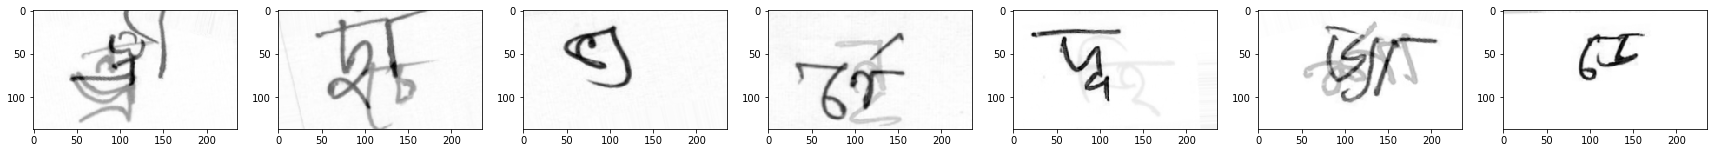

In [67]:
if 1: 
  batch_x,y = next(g3_datagen_fs)
  import matplotlib.pyplot as plt
  fig, axs = plt.subplots(1, 7, figsize=(30, 30))
  for i in range(7):
    axs[i].imshow(batch_x[i,:,:,0], cmap='gray')
  plt.show()

In [0]:
if 0: opt = Lookahead(tf.keras.optimizers.SGD(learning_rate=LR_MAX, momentum=0.9,nesterov=True))

opt=tf.keras.optimizers.Adam(learning_rate=LR_MAX)

In [0]:
checkpoint =  tf.train.Checkpoint(latest_epoch=tf.Variable(0), optimizer=opt, model=model)
chkp_manager =  tf.train.CheckpointManager(checkpoint, CHKP_DIR, max_to_keep=3)

In [0]:
chkp_manager.latest_checkpoint

In [71]:
chkp_restore_status=checkpoint.restore(chkp_manager.latest_checkpoint)
if chkp_manager.latest_checkpoint:
  #chkp_restore_status.assert_consumed()
  print("Restored from {}".format(chkp_manager.latest_checkpoint))
  print(f"Lastest epoch {checkpoint.latest_epoch.numpy()}")
else:
  print("Initializing from scratch.")

Initializing from scratch.


In [0]:
loss_dict={'root':    'categorical_crossentropy',
           'vowel':    'categorical_crossentropy',
           'consonant':'categorical_crossentropy'}
model.compile(optimizer=opt, loss=loss_dict, loss_weights=[2.0,1.0,1.0])

In [0]:
initial_epoch = checkpoint.latest_epoch.numpy()

print(f'epochs trained: {initial_epoch}. start training epoch {initial_epoch+1}...')
#ca_shed = CosineAnnealingScheduler(T_max=T_MAX, eta_max=LR_MAX, eta_min=LR_MIN,verbose=1, initial_epoch=initial_epoch-130)
rolrplt = tf.keras.callbacks.ReduceLROnPlateau(monitor='kaggle',mode='max', patience=5, verbose=1, factor=0.5, min_lr=LR_MIN)


suffix =EXPERIMENT+\
                '_eps'+str(EPOCHS)+\
                '_iniep'+str(initial_epoch)+\
                '_sz'+str(IMG_SIZE)+\
                '_bs'+str(BATCH_SIZE)+\
                '_do'+str(DROP_OUT)+\
                '_'+model.optimizer.get_config()['name']+\
                '_IS_fold'+str(FOLD)


kv = KaggleValidationFS(valid_df,
                      batch_size=512,
                      vals_per_epoch=1,
                      train_steps=train_m//BATCH_SIZE+1,
                      logfile=EXPERIMENT_DIR+'log_kr_'+suffix+'.csv',
                      initial_epoch=initial_epoch,
                      suffix = suffix,
                      train_img_dir=TRAIN_IMG_DIR,
                      output_dir=EXPERIMENT_DIR,
                      thresholds=[0.975,0.995,0.993],
                      chkp_manager=chkp_manager,
                      in_shape=[HEIGHT,WIDTH],
                      st=STATS_FS_WOINORM)


cbs = [kv,rolrplt]

history=model.fit(g3_datagen_fs,
                  epochs=EPOCHS,
                  steps_per_epoch=train_m//BATCH_SIZE+1,
                  callbacks=cbs,
                  class_weight=model_cw,
                  verbose=2)

epochs trained: 0. start training epoch 1...
Train for 1491 steps
Epoch 1/200

batch 1490: validation...



[0:23:45] - kaggle:0.8021 - root:0.6920 -vowel:0.8974 - cons: 0.9268

saved checkpoint for epoch 1: /content/drive/My Drive/kaggle/bengali/output/sernext_fs_woinorm/chkp/ckpt-1

1491/1491 - 1428s - loss: 8.8475 - root_loss: 3.3059 - vowel_loss: 1.1785 - consonant_loss: 1.0571
Epoch 2/200

batch 1490: validation...



[0:47:53] - kaggle:0.8872 - root:0.8282 -vowel:0.9418 - cons: 0.9506

saved checkpoint for epoch 2: /content/drive/My Drive/kaggle/bengali/output/sernext_fs_woinorm/chkp/ckpt-2

1491/1491 - 1447s - loss: 4.6936 - root_loss: 1.6598 - vowel_loss: 0.7355 - consonant_loss: 0.6386
Epoch 3/200

batch 1490: validation...



[1:11:07] - kaggle:0.8938 - root:0.8478 -vowel:0.9468 - cons: 0.9328

saved checkpoint for epoch 3: /content/drive/My Drive/kaggle/bengali/output/sernext_fs_woinorm/chkp/ckpt-3

1491/1491 - 1395s - loss: 4.0448 - root_loss: 1.4106 - vowel_loss: 0.6624 - consonant_loss: 0.5613
Epoch 4/200

batch 1490: validation...



[1:34:50] - kaggle:0.8497 - root:0.8017 -vowel:0.8947 - cons: 0.9005

saved checkpoint for epoch 4: /content/drive/My Drive/kaggle/bengali/output/sernext_fs_woinorm/chkp/ckpt-4

1491/1491 - 1423s - loss: 3.7710 - root_loss: 1.3097 - vowel_loss: 0.6236 - consonant_loss: 0.5281
Epoch 5/200

batch 1490: validation...



[1:58:09] - kaggle:0.9201 - root:0.8902 -vowel:0.9389 - cons: 0.9612

saved checkpoint for epoch 5: /content/drive/My Drive/kaggle/bengali/output/sernext_fs_woinorm/chkp/ckpt-5

1491/1491 - 1399s - loss: 3.4294 - root_loss: 1.1910 - vowel_loss: 0.5652 - consonant_loss: 0.4823
Epoch 6/200

batch 1490: validation...



[2:21:58] - kaggle:0.9484 - root:0.9211 -vowel:0.9748 - cons: 0.9767

saved checkpoint for epoch 6: /content/drive/My Drive/kaggle/bengali/output/sernext_fs_woinorm/chkp/ckpt-6

1491/1491 - 1428s - loss: 3.3178 - root_loss: 1.1559 - vowel_loss: 0.5504 - consonant_loss: 0.4556
Epoch 7/200

batch 1490: validation...



[2:45:35] - kaggle:0.6417 - root:0.5505 -vowel:0.7444 - cons: 0.7212

saved checkpoint for epoch 7: /content/drive/My Drive/kaggle/bengali/output/sernext_fs_woinorm/chkp/ckpt-7

1491/1491 - 1418s - loss: 3.1101 - root_loss: 1.0847 - vowel_loss: 0.5112 - consonant_loss: 0.4296
Epoch 8/200

batch 1490: validation...



[3:09:10] - kaggle:0.6572 - root:0.5225 -vowel:0.8024 - cons: 0.7813

saved checkpoint for epoch 8: /content/drive/My Drive/kaggle/bengali/output/sernext_fs_woinorm/chkp/ckpt-8

1491/1491 - 1415s - loss: 2.9107 - root_loss: 1.0088 - vowel_loss: 0.4813 - consonant_loss: 0.4118
Epoch 9/200

batch 1490: validation...



[3:32:58] - kaggle:0.9571 - root:0.9368 -vowel:0.9771 - cons: 0.9777

saved checkpoint for epoch 9: /content/drive/My Drive/kaggle/bengali/output/sernext_fs_woinorm/chkp/ckpt-9

1491/1491 - 1428s - loss: 2.9747 - root_loss: 1.0301 - vowel_loss: 0.4985 - consonant_loss: 0.4160
Epoch 10/200

batch 1490: validation...



[3:56:09] - kaggle:0.9522 - root:0.9321 -vowel:0.9747 - cons: 0.9698

saved checkpoint for epoch 10: /content/drive/My Drive/kaggle/bengali/output/sernext_fs_woinorm/chkp/ckpt-10

1491/1491 - 1390s - loss: 2.8907 - root_loss: 0.9994 - vowel_loss: 0.4820 - consonant_loss: 0.4100
Epoch 11/200

batch 1490: validation...



[4:19:08] - kaggle:0.9079 - root:0.8991 -vowel:0.8926 - cons: 0.9405

saved checkpoint for epoch 11: /content/drive/My Drive/kaggle/bengali/output/sernext_fs_woinorm/chkp/ckpt-11

1491/1491 - 1379s - loss: 2.7981 - root_loss: 0.9654 - vowel_loss: 0.4681 - consonant_loss: 0.3991
Epoch 12/200

batch 1490: validation...



[4:42:08] - kaggle:0.9631 - root:0.9442 -vowel:0.9816 - cons: 0.9823

saved checkpoint for epoch 12: /content/drive/My Drive/kaggle/bengali/output/sernext_fs_woinorm/chkp/ckpt-12

1491/1491 - 1381s - loss: 2.7183 - root_loss: 0.9400 - vowel_loss: 0.4552 - consonant_loss: 0.3831
Epoch 13/200

batch 1490: validation...



[5:05:25] - kaggle:0.9562 - root:0.9364 -vowel:0.9785 - cons: 0.9735

saved checkpoint for epoch 13: /content/drive/My Drive/kaggle/bengali/output/sernext_fs_woinorm/chkp/ckpt-13

1491/1491 - 1397s - loss: 2.6178 - root_loss: 0.9013 - vowel_loss: 0.4435 - consonant_loss: 0.3716
Epoch 14/200

batch 1490: validation...



[5:29:06] - kaggle:0.9622 - root:0.9433 -vowel:0.9822 - cons: 0.9798

saved checkpoint for epoch 14: /content/drive/My Drive/kaggle/bengali/output/sernext_fs_woinorm/chkp/ckpt-14

1491/1491 - 1421s - loss: 2.7882 - root_loss: 0.9590 - vowel_loss: 0.4752 - consonant_loss: 0.3950
Epoch 15/200


In [0]:
model.optimizer.get_config()